# Model Bootstrapping
In this notebook, we'll use random sampling with replacement (bootstrapping) to assign measures of accuracy to sample estimates of our OLS coeffecients and their standard errors and p-values. For each model we fit, we'll also plug in values for a new simulated observation where all of the control variables equal their expected value and only the interaction terms of interest are randomly drawn from a uniform distribution of the sample. 

With the results, we can:

 - plot the predicted values against the booking days for each of the four fare groups. We could plot the confidence interval for each line as well.
 - plot/describe the confidence intervals for the p-values, coeffecients and standard errors in comparison to the model fitted on the entire dataset.

## Imports

In [1]:
import os
import random
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm

from models.models import Segment 

## Fit Model One

In [2]:
#Using model 1
model = Segment().model_1()

#this is the data we are using 
df = model.model_data

formula = (
           "cost_per_mile ~   market_share_log  + month + day_of_week + C(Year) + "
           "no_CA_award + booking_days_standarized + booking_days_standarized*C(fare_type, "
           "Treatment(reference='Dash CA')) + city_pair_code + self_booking_indicator"
          )
#this model uses the standarized booking advanced days
result = sm.ols(formula = formula, data = df).fit()
result.summary()

preparing data


/Users/charlessmcallister/.local/share/virtualenvs/travel-project-report-S1-ev3MJ/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3296: DtypeWarning: Columns (7,8,15,16,24,25,26,27,71,72,74,75,79,85,130) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          cost_per_mile   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     1944.
Date:                Tue, 04 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:01:33   Log-Likelihood:                 41447.
No. Observations:               26189   AIC:                        -8.269e+04
Df Residuals:                   26086   BIC:                        -8.185e+04
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================
                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                          0.4296      0.004    119.892      0.000       0.423       0.437
month[T.August]                                                                   -0.0015      0.001     -1.053      0.292      -0.004       0.001
month[T.December]                                                                  0.0047      0.002      2.516      0.012       0.001       0.008
month[T.February]                                                                 -0.0076      0.002     -4.988      0.000      -0.011      -0.005
month[T.January]                                                                  -0.0050      0.002     -3.011      0.003      -0.008      -0.002
month[T.July]                                                                      0.0053      0.002      3.281      0.001       0.002       0.008
month[T.June]                                                                      0.0040      0.002      2.656      0.008       0.001       0.007
month[T.March]                                                                     0.0023      0.001      1.621      0.105      -0.000       0.005
month[T.May]                                                                      -0.0074      0.001     -5.065      0.000      -0.010      -0.005
month[T.November]                                                                  0.0089      0.002      5.244      0.000       0.006       0.012
month[T.October]                                                                   0.0070      0.002      4.256      0.000       0.004       0.010
month[T.September]                                                                 0.0019      0.002      1.250      0.211      -0.001       0.005
day_of_week[T.Monday]                                                             -0.0035      0.001     -3.409      0.001      -0.005      -0.001
day_of_week[T.Saturday]                                                           -0.0049      0.002     -2.001      0.045      -0.010     -0.0001
day_of_week[T.Sunday]                                                              0.0002      0.001      0.179      0.858      -0.002       0.003
day_of_week[T.Thursday]                                                           -0.0009      0.001     -0.891      0.373      -0.003       0.001
day_of_week[T.Tuesday]                                                            -0.0073      0.001     -6.597      0.000      -0.009      -0.005
day_of_week[T.Wednesday]                                                          -0.0047      0.001     -4.129      0.000      -0.007      -0.

## Bootstrap Resampling
Adjust `n` below to change the number of iterations.

In [11]:
def bootstrap_resample(df, formula, n = 10000, booking_days_col = 'booking_days_standarized'):
    '''
    Given a dataframe and OLS formula, bootstrap n times. Fit a model with each iteration, saving the results.
    Also randomly generate a new data point with the expected value for the control variables and randomly generated
    values for the variables of interest. Save that predicted value along with the randomly adjusted inputs.
    '''
    #specify control vars of interest from the model specification, distinguishing between factors and continuous vars
    exog_cont = ['cost_per_mile', 'market_share_log']
    exog_fact = ['month', 'day_of_week', 'Year', 'no_CA_award', 'city_pair_code', 'self_booking_indicator']

    #get expected values for these control variables
    fixed_exog_cont = pd.DataFrame(df[exog_cont].mean()).transpose()
    fixed_exog_fact = df[exog_fact].mode()

    #combine these expected values into a df that'll be re-used in each iteration
    new_sample = pd.concat([fixed_exog_cont, fixed_exog_fact], axis = 1)

    #get list of unique fare types to randomly draw from in each iteration
    fare_types = df['fare_type'].unique()


    values_to_save = ['std_err', 'params', 'p_values', 'y_pred', 'random_fare_type', f'random_{booking_days_col}']
    data = {k:[] for k in values_to_save}
    for i in range(n):
        #create bootstrap sample and fit a model using that sample
        rand_df = df.sample(n = df.shape[0], replace = True, random_state = 123)
        rand_result = sm.ols(formula = formula, data = rand_df).fit()

        #get the coeffecients, standard errors, and p-values
        params = rand_result.params.to_dict()
        p_values = rand_result.pvalues.to_dict()
        std_err = rand_result.bse.to_dict()

        #randomly generate a value for the new sample's booking_days_standardized and fare type and get y-hat
        random_booking_days_standarized = random.uniform(0,1) 
        random_fare_type = random.choice(fare_types)
        #concat the random values with the new_sample df created outside the loop
        _df = pd.DataFrame([random_fare_type, random_booking_days_standarized]).transpose()
        _df.columns = ['fare_type', booking_days_col]
        new_df = pd.concat([new_sample, _df], axis = 1)
        #need to make dtypes same as those when the model was fit
        new_df[booking_days_col] = new_df[booking_days_col].astype(float)
        y_pred = rand_result.predict(new_df.iloc[0:1]).iloc[0]

        #save values
        data['params'].append(params)
        data['p_values'].append(p_values)
        data['std_err'].append(std_err)
        data['y_pred'].append(y_pred)
        data['random_fare_type'].append(random_fare_type)
        data[f'random_{booking_days_col}'].append(random_booking_days_standarized)

        #log progress
        if i % 1000 == 0 and i != 0:
            print( f"Done with {i} iterations.")
            
    return data

In [4]:
data = bootstrap_resample(df, formula)
bootstrap_results = pd.DataFrame(data)
bootstrap_results.head()
bootstrap_results.to_csv('bootstrap_results.csv', index = False)

# Fit Model Two

In [12]:
formula_log = (
               "cost_per_mile ~   market_share_log  + month + day_of_week + C(Year) + "
               "no_CA_award + booking_days_log + booking_days_log*C(fare_type, "
               "Treatment(reference='Dash CA')) + city_pair_code + self_booking_indicator"
              )
#this model uses the standarized booking advanced days
result_log = sm.ols(formula = formula_log, data = df).fit()
result_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          cost_per_mile   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     1960.
Date:                Tue, 04 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:11:17   Log-Likelihood:                 41538.
No. Observations:               26189   AIC:                        -8.287e+04
Df Residuals:                   26086   BIC:                        -8.203e+04
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  0.4330      0.004    112.268      0.000       0.425       0.441
month[T.August]                                                           -0.0018      0.001     -1.216      0.224      -0.005       0.001
month[T.December]                                                          0.0050      0.002      2.691      0.007       0.001       0.009
month[T.February]                                                         -0.0076      0.002     -5.027      0.000      -0.011      -0.005
month[T.January]                                                          -0.0055      0.002     -3.315      0.001      -0.009      -0.002
month[T.July]                                                              0.0051      0.002      3.189      0.001       0.002       0.008
month[T.June]                                                              0.0038      0.002      2.552      0.011       0.001       0.007
month[T.March]                                                             0.0023      0.001      1.583      0.113      -0.001       0.005
month[T.May]                                                              -0.0072      0.001     -4.946      0.000      -0.010      -0.004
month[T.November]                                                          0.0093      0.002      5.491      0.000       0.006       0.013
month[T.October]                                                           0.0067      0.002      4.062      0.000       0.003       0.010
month[T.September]                                                         0.0019      0.002      1.225      0.221      -0.001       0.005
day_of_week[T.Monday]                                                     -0.0046      0.001     -4.487      0.000      -0.007      -0.003
day_of_week[T.Saturday]                                                   -0.0056      0.002     -2.300      0.021      -0.010      -0.001
day_of_week[T.Sunday]                                                     -0.0008      0.001     -0.618      0.537      -0.004       0.002
day_of_week[T.Thursday]                                                   -0.0016      0.001     -1.538      0.124      -0.004       0.000
day_of_week[T.Tuesday]                                                    -0.0086      0.001     -7.716      0.000      -0.011      -0.006
day_of_week[T.Wednesday]                                                  -0.0059      0.001     -5.246      0.000      -0.008      -0.004
C(Year)[T.2016.0]                                                          0.0013      0.001      0.915      0.360      -0.002       0.004
C(Year)[T.2017.0]        

In [13]:
data_log = bootstrap_resample(df, formula_log, booking_days_col = 'booking_days_log')
bootstrap_results_log = pd.DataFrame(data_log)
bootstrap_results_log.head()
bootstrap_results_log.to_csv('bootstrap_results_log.csv', index = False)

Done with 1000 iterations.
Done with 2000 iterations.
Done with 3000 iterations.
Done with 4000 iterations.
Done with 5000 iterations.
Done with 6000 iterations.
Done with 7000 iterations.
Done with 8000 iterations.
Done with 9000 iterations.


# Plot predicted values
Here we'll plot the predicted values against the randomly generated `booking_days_standardized` for each `fare_type`.

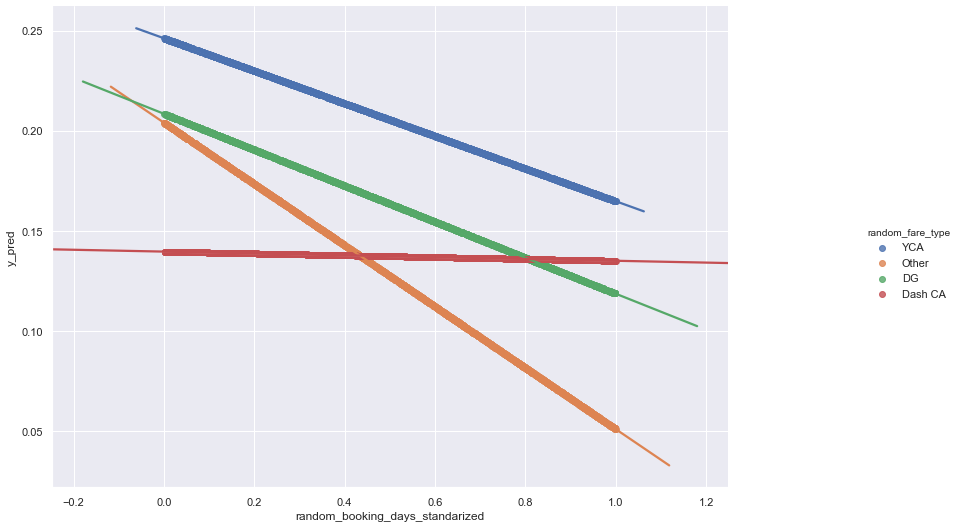

In [15]:
#standardized booking_days
sns.set(color_codes = True)
g = sns.lmplot(x = "random_booking_days_standarized",
               y = "y_pred",
               hue = "random_fare_type",
               data = bootstrap_results)
g.fig.set_size_inches(15, 8)

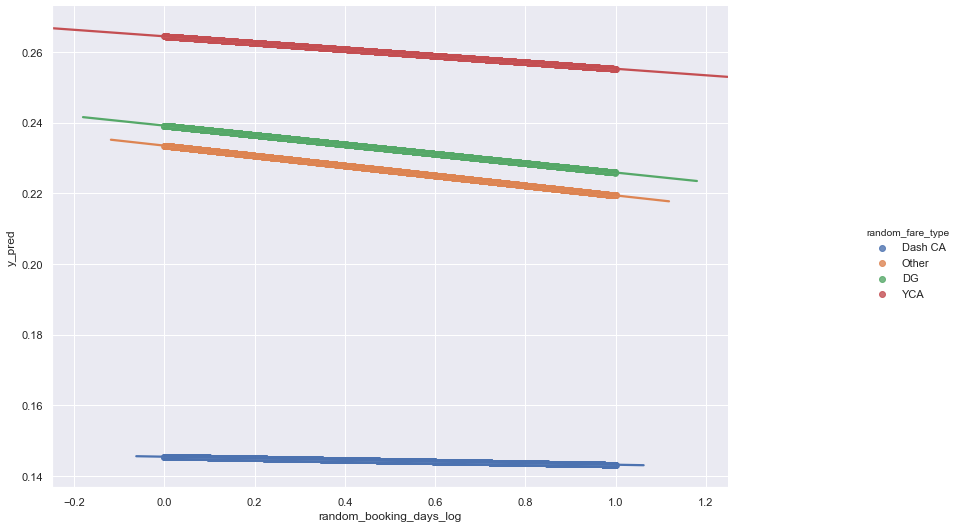

In [14]:
# log transformed booking days
sns.set(color_codes = True)
g_log = sns.lmplot(x = "random_booking_days_log",
                   y = "y_pred",
                   hue = "random_fare_type",
                   data = bootstrap_results_log)
g_log.fig.set_size_inches(15, 8)